In [64]:
from contextlib import nullcontext
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pandas as pd; import pymc as pm; import arviz as az
np.random.seed(365)
#import the data
mu_0,sigma_0=0,10
loc_prior = stats.norm(loc=mu_0, scale=sigma_0) # mean=mu_0 / std=sigma_0
scale_prior = stats.halfnorm(scale=5) # std=1
df_prior = stats.randint(low=1, high=101) # df ~ Unif{1, 2, ..., 100}

n,loc_true,scale_true,df_true = 100,10,2,15 # True values data will be from... IRL, we don't know these values
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n) # Data from location-scale-t distribution

halfnorm_toy_model = pm.Model()
with halfnorm_toy_model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    tau_sq = pm.HalfNormal("tau_sq", sigma=1)
    nu = pm.DiscreteUniform("nu", lower=1, upper=100)
    x_obs = pm.StudentT("likelihood",nu =nu, mu=mu, sigma=1/(tau_sq**0.5), observed=x)
    idata_HMC = pm.sample(draws=5000)




HMC Split-Rhats {'mu': 1.0013, 'nu': 1.0566, 'tau_sq': 1.0292} | 

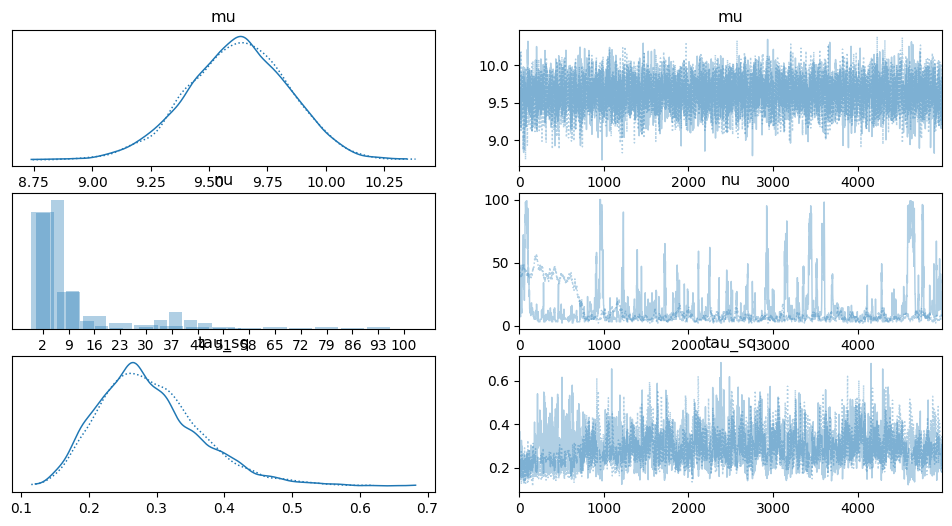

In [65]:
az.plot_trace(idata_HMC);
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | ');

Autocorrelation for HMC (MCMC) chain 0.254542026735185
Autocorrelation for HMC (MCMC) chain 0.613908967835735
Autocorrelation for HMC (MCMC) chain 0.9731621678127258


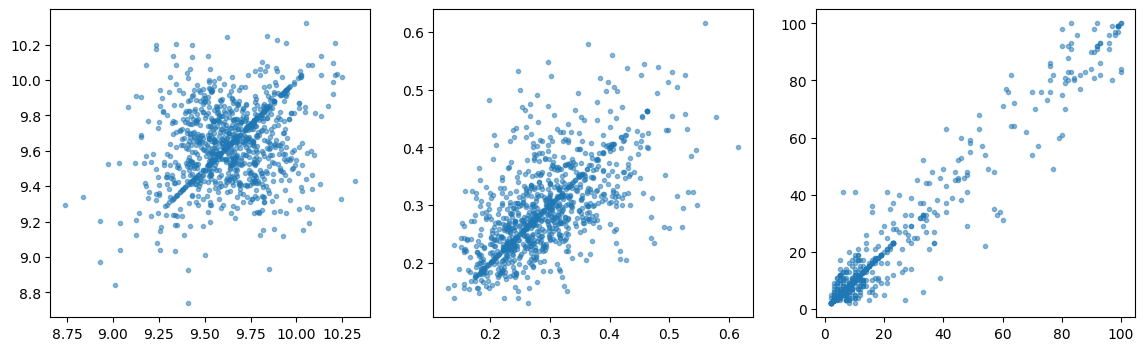

In [66]:
fig,ax = plt.subplots(1,3, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["mu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["mu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

mcmc_chain = idata_HMC.posterior["tau_sq"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["tau_sq"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

mcmc_chain = idata_HMC.posterior["nu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["nu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[2].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

#

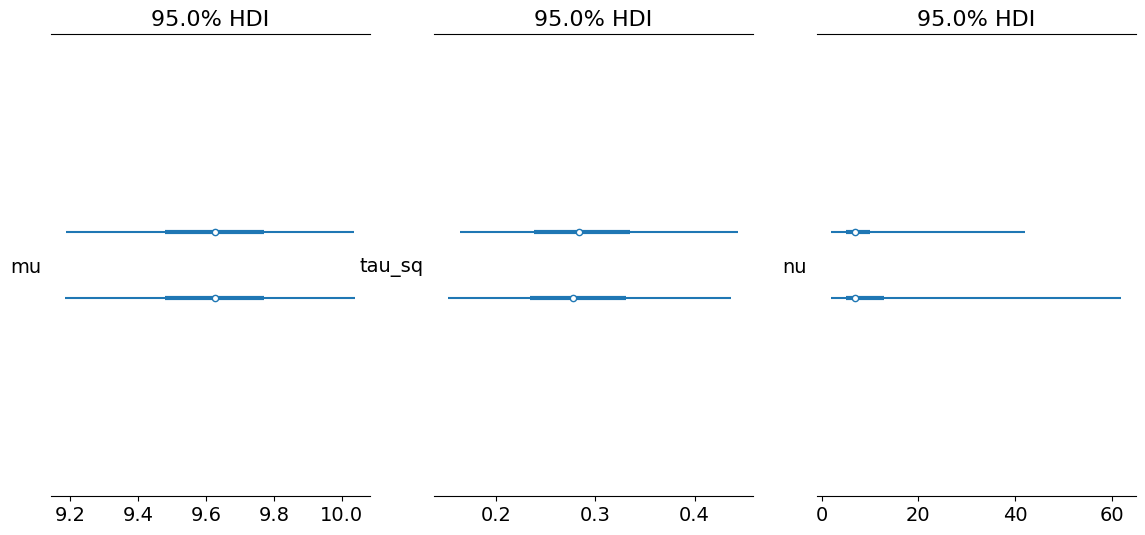

In [67]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,3, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["mu"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["tau_sq"], combined=False, hdi_prob=0.95, ax=ax[1]);
az.plot_forest(idata_HMC, var_names=["nu"], combined=False, hdi_prob=0.95, ax=ax[2]);



The 95% credible interval for the posterior of mu lies around 9.2 and 10.2 for both chains. This is reiliable as the data converges and small correlation within the chain.
The 95% credible interval for the posterior of tau squared lies around 0.1 to 0.5 for the first chain and round the second chain 0.1 to 0.45. This is not as reiliable as mu as two chains have different HDI. However, they are close the data converges and moderate correlation within the chain, thus the  credible interval could be reliable.
The 95% credible interval for the posterior of nu lies around 0 to 42 for the first chain and round the second chain 0 to 61. This is not reiliable as mu as two chains have very different HDI. Even though the data converges, but there exists very high correlation within the chain, thus the credible interval is not reliable.

---
Part 2

In [74]:

import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(idata_HMC)[:1]['ess_bulk']}),
 pd.DataFrame({'Centered': pm.summary(idata_HMC)[1:]['ess_bulk']})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered
mu,5802.0
nu,49.0
tau_sq,69.0


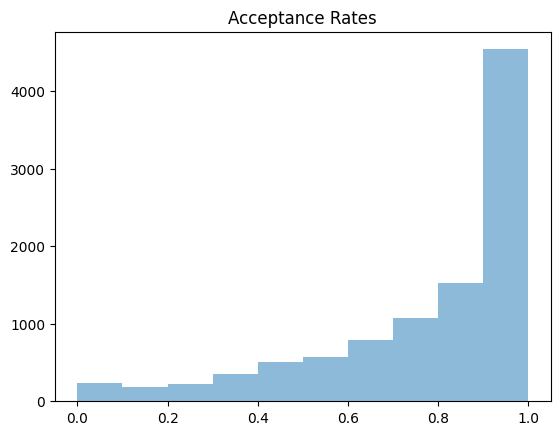

In [78]:
import matplotlib.pyplot as plt
plt.hist(idata_HMC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5);
plt.title('Acceptance Rates');

There are no divergence for both chains shown above. Also from the output above, all three parameters seem to be convered. Rhats fro mu is 1.0013, nu is 1.0566 and tau_sq is 1.0292. However, the correlation within the chain of nu is really high, thus its credible interval might not be reliable. tau_sq also has a moderate correlation within the chain itself. But mu's correlation is low.


In [89]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])


import pymc as pm


with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

pm.model_to_graphviz(Centered_eight)
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains

import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
#_log.setLevel(logging.INFO) # 20
_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

# We now see that the NUTS implementation (version of HMC) is being used to
# sample from the posterior distributions of our parameters [mu, tau, theta]
SEED = [20100420, 20134234]
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})



Centered_eight Split-Rhats {'mu': 1.0055, 'theta': array([1.0065, 1.0039, 1.0032, 1.0046, 1.0017, 1.0035, 1.006 , 1.0024]), 'tau': 1.0226} | 

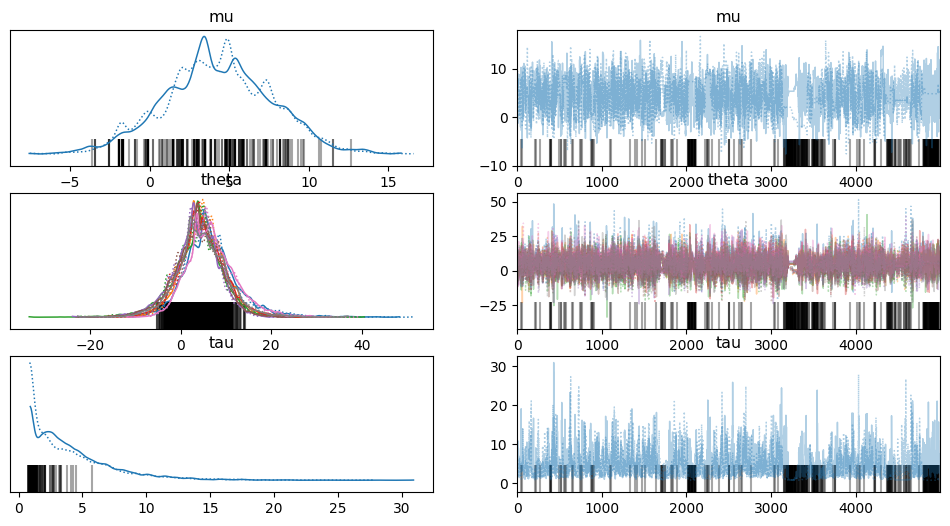

In [90]:
az.plot_trace(fit_C);
print("Centered_eight Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_C).items()}, end=' | ');

Autocorrelation for HMC (MCMC) chain 0.5093692150419411
Autocorrelation for HMC (MCMC) chain 0.6014723782970303
Autocorrelation for HMC (MCMC) chain -0.5419667117813864


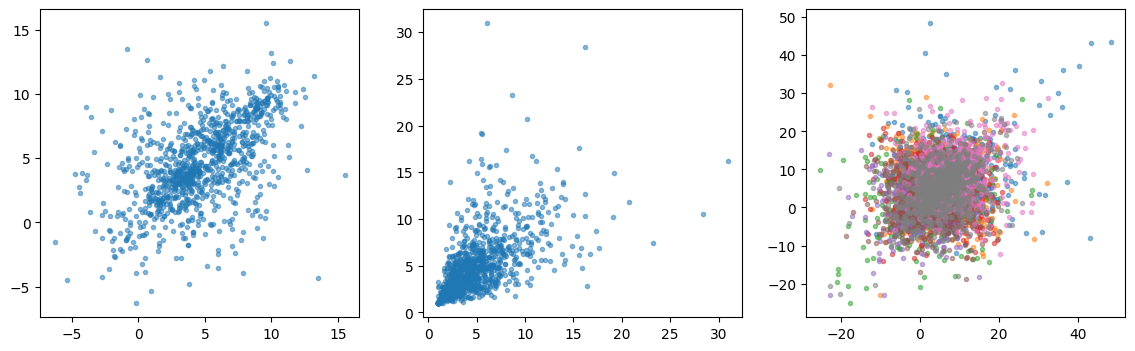

In [92]:
fig,ax = plt.subplots(1,3, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = fit_C.posterior["mu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fit_C.posterior["mu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for mu (Centered) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

mcmc_chain = fit_C.posterior["tau"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fit_C.posterior["tau"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for tau (Centered) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

mcmc_chain = fit_C.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fit_C.posterior["theta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[2].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for theta (Centered) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

For the centered eight school model, there are many divergences for the frist  chain shown above. The second chain has even more divergences up to 283. Also based from the output above, all three parameters seem to be divergences. Rhats fro mu is 1.0055, theta is the array [1.0065, 1.0039, 1.0032, 1.0046, 1.0017, 1.0035, 1.006 , 1.0024] and tau is 1.0226. Moreover, the correlation within the chain of all three paremeters are high within the chains. It is worth noticing that because theta is an array, so the AC for theta might not be accurate. After using logging, there are no warrning nor error for the chains.  


In [86]:
with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)
with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})


NonCentered_eight Split-Rhats {'mu': 1.0001, 'theta_t': array([1.0001, 1.0002, 1.    , 0.9999, 1.0002, 1.    , 1.0001, 1.0016]), 'tau': 1.0001, 'theta': array([1.0002, 1.0002, 1.    , 1.0006, 1.0007, 0.9999, 0.9999, 1.    ])} | 

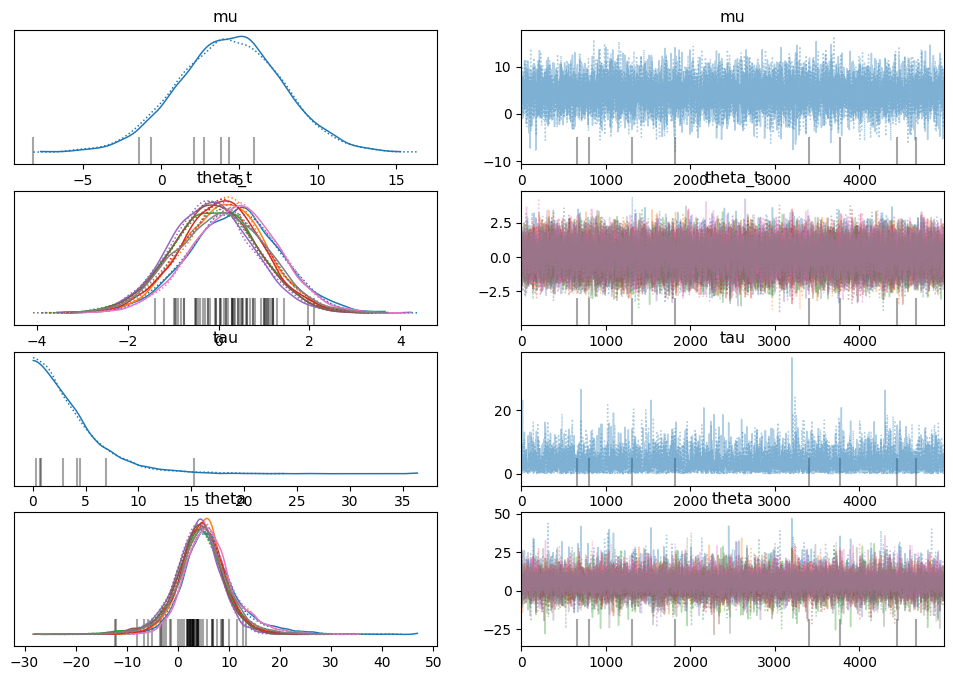

In [91]:
az.plot_trace(fit_NC);
print("NonCentered_eight Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(fit_NC).items()}, end=' | ');

In [114]:
import pandas as pd
print("Effective Sample Sizes (function of Markov Chain autocorrelation dependency)")
pd.concat(
[pd.DataFrame({'Centered': pm.summary(fit_C)[:1]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][:1]}),
 pd.DataFrame({'Centered': pm.summary(fit_C)[1:]['ess_bulk'],
              'Non-Centered': pm.summary(fit_NC)['ess_bulk'][9:]})])

Effective Sample Sizes (function of Markov Chain autocorrelation dependency)


,Centered,Non-Centered
mu,623.0,11120.0
tau,129.0,5121.0
theta[0],538.0,10859.0
theta[1],978.0,11965.0
theta[2],1575.0,11071.0
theta[3],965.0,12523.0
theta[4],1673.0,11294.0
theta[5],1769.0,10616.0
theta[6],415.0,11073.0
theta[7],1248.0,11415.0


Autocorrelation for mu (NonCentered_eight) chain -0.029528135854327616
Autocorrelation for tau (NonCentered_eight) chain 0.0574886753711974
Autocorrelation for theta_t (NonCentered_eight) chain -0.4510156507510092
Autocorrelation for theta (NonCentered_eight ) chain -0.4510156507510091


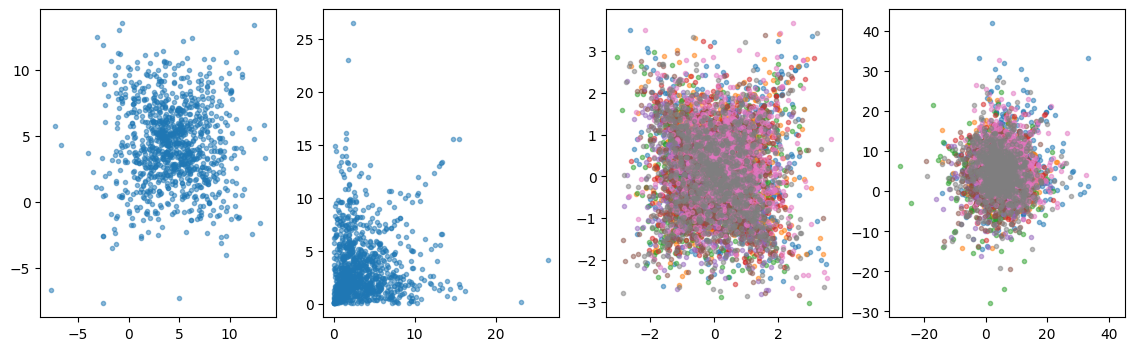

In [110]:
fig,ax = plt.subplots(1,4, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = fit_NC.posterior["mu"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fit_NC.posterior["mu"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for mu (NonCentered_eight) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

mcmc_chain = fit_NC.posterior["tau"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fit_NC.posterior["tau"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for tau (NonCentered_eight) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

mcmc_chain = fit_NC.posterior["theta_t"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fit_NC.posterior["theta_t"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[2].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for theta_t (NonCentered_eight) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = fit_NC.posterior["theta"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = fit_NC.posterior["theta"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[3].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for theta (NonCentered_eight ) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

For the non-centered eight school model, there are a lot less divergences for both chains as there are only a few divergences for 5000 draws. Also based from the output above, all four parameters are a lot better now. Rhats fro mu is 1.0001, theta is the array [1.0002, 1.0002, 1.    , 1.0006, 1.0007, 0.9999, 0.9999, 1.] and tau is 1.0001. Moreover, the correlation within the chain of mu and tau paremeters are very low within the chains. But since theta and theta_tilde are arrays, so the AC for theta might not be accurate. However, the shape of the two parameters doesn't not look like high correlation within the chains. After using logging, there are also no warrning nor error for the non-centered eight school model chains.

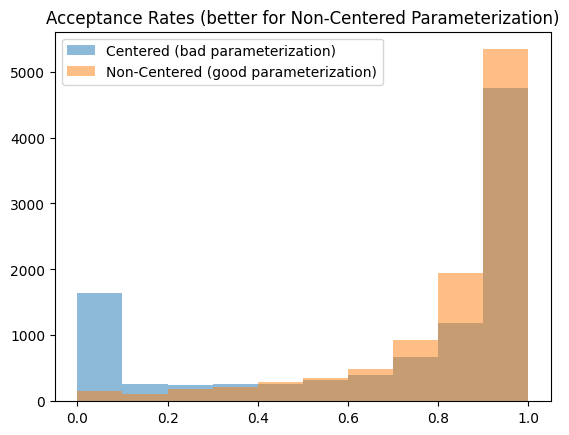

In [83]:
import matplotlib.pyplot as plt
plt.hist(fit_C.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Centered (bad parameterization)');
plt.hist(fit_NC.sample_stats.acceptance_rate.values.flatten(), alpha=0.5,
         label='Non-Centered (good parameterization)');
plt.title('Acceptance Rates (better for Non-Centered Parameterization)'); plt.legend();


This is the acceptance rates for two models.l We see that the aceptance rate is a lot better from non-center model as it is 5000 at 1.0.

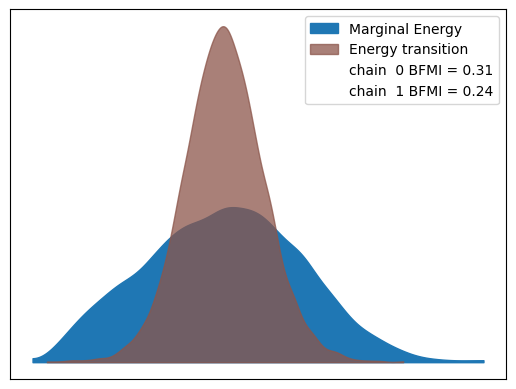

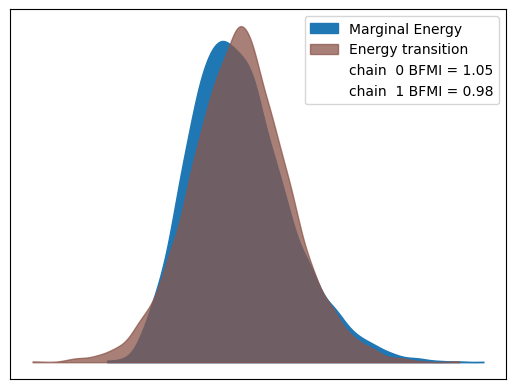

In [111]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

We see the energy plot for the centered school model, the marginal energy distribution and quite different than energy transition distribution. This means the NUTS algorithm was not able to adequately explore. On the other hand, the non-centered school model, the distribvution of marginal energy and energy transition are similiar. Thus we can conclude that the NUTS algorithm can explore adequately.